# Using the Uncertainties Package

This tutorial is meant to give a more in-depth introduction to error analysis using the [uncertainties](https://pythonhosted.org/uncertainties/index.html) Python package. There are limitations to this package, and so I'll also go through what to do when it fails.

In [1]:
import numpy as np
import uncertainties

## Simple Example

Let's begin with a simple example, a multivariate function with a single output.

In [2]:
def func(a, b):
    f = np.sin(a) * np.cos(b)
    return f

In [3]:
a = 1
b = 2
func(a, b)

-0.35017548837401463

In preparation for using the `uncertainties` package, let's instead make the input an array that is then broken down within the function.

In [4]:
def func(arg):
    a, b = arg
    f = np.sin(a) * np.cos(b)
    return f

In [5]:
a = 1
b = 2
func([a, b])

-0.35017548837401463

The `uncertainties` package comes with a version of `numpy` that tracks uncertainties on each element of an array. This new version of `numpy` also contains new versions of basic math functions.

In [6]:
from uncertainties import unumpy as unp

def func(arg):
    a, b = arg
    f = unp.sin(a) * unp.cos(b)
    return f

Notice here that instead of `numpy.sin()`, I'm now using `unumpy.sin()`. Evaluating the function as we did before, you'll notice that the output now includes uncertainties.

In [7]:
a, b = 1, 2
sigma_a, sigma_b = 1e-2, 1e-3
arg = unp.uarray([a, b], [sigma_a, sigma_b])
func(arg)

-0.35017548837401463+/-0.002375075206522318

# Advanced Example

Let's look at a more complex example. Suppose we have a spectral fit with desired wavelengths and fit parameters to a spectral line, and we want to calculate the uncertainties on the line luminosity. Starting with the typical way the line luminosity is calculated:

In [8]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def lum(x, y):
    return np.trapz(y, x)

x = np.linspace(1500, 1600, 1000)
mu = 1550
sig = 10
y = gaussian(x, mu, sig)
print('Line luminosity:', lum(x, y))

Line luminosity: 25.066268372619653


Now let's transform it to make it usable with the `uncertainties` package, and make up some uncertainties for mu and sigma.

In [9]:
def gaussian(x, arg):
    mu, sig = arg
    return unp.exp(-(x - mu)**2 / (2 * sig**2.))

x = np.linspace(1500, 1600, 1000)
arg = unp.uarray([1550, 10], [20, 1])
y = gaussian(x, arg)
print(y[:10])

[3.726653172078671e-06+/-3.841346164630867e-05
 3.9177225697456615e-06+/-4.029737145145262e-05
 4.118175631742447e-06+/-4.226927684726753e-05
 4.328451283391477e-06+/-4.433306285004109e-05
 4.549007856918783e-06+/-4.649277489471186e-05
 4.780323894003468e-06+/-4.875262493257592e-05
 5.02289897888897e-06+/-5.111699773693195e-05
 5.277254603087473e-06+/-5.359045742258942e-05
 5.543935062755593e-06+/-5.617775418545652e-05
 5.82350838985245e-06+/-5.888383126857489e-05]


There's a few things to notice here. 
* We don't have uncertainties on the wavelengths, so I set the `gaussian()` function to accept the wavelengths and fit parameters (which do have uncertainties) separately.
* If, for example, mu did not have uncertainties, we could have simply set the mu uncertainty to zero.
* Notice that each output flux element has an uncertainty associated with it, I've printed out the first 10.

Now calculating the line luminosity, it turns out we don't need to make any adjustments to the function:

In [10]:
def lum(x, y):
    return np.trapz(y, x)

print('Line luminosity:', lum(x, y))

Line luminosity: 25.1+/-2.5


# What to do if it fails

In writing this tutorial I noticed that there are times where `uncertainties` simply cannot calculate errors. One of those times is when trying to calculate the FWHM, it cannot calculate a UnivariateSpline using `unumpy.uarray` objects. We can handle these edge cases manually, using a Monte Carlo technique.

In this technique, we know the uncertainties on our fit parameters, mu and sigma. We can vary mu and sigma according to their uncertainties to generate new, slightly different versions of the spectral line. First we generate 1000 new values of mu and sigma:

In [11]:
mu_orig = 1550
sig_orig = 20

mu_err = 5
sig_err = 1

mu_new = np.random.normal(loc=mu_orig, scale=mu_err, size=1000)
sig_new = np.random.normal(loc=sig_orig, scale=sig_err, size=1000)

So now instead of single mu and sigma values, we have generated distributions according to their uncertainties:

Text(0.5, 0, '$\\sigma$')

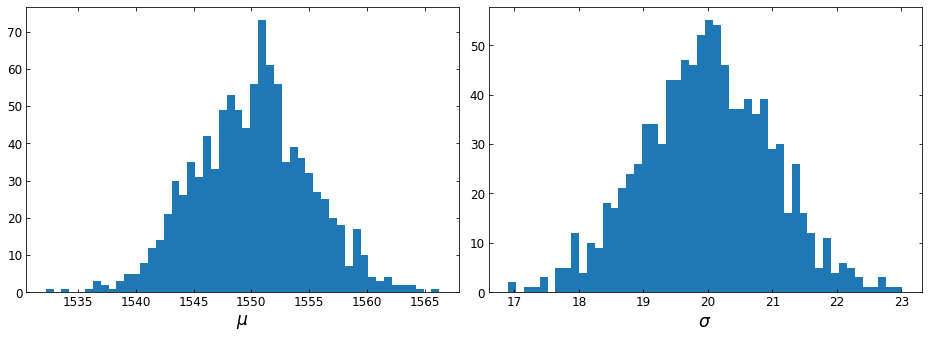

In [12]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4.8))
ax1.hist(mu_new, bins=50)
ax2.hist(sig_new, bins=50)
ax1.set_xlabel(r'$\mu$')
ax2.set_xlabel(r'$\sigma$')

Then we plug these into our gaussian  function to get 1000 new flux arrays, each slightly different.

In [13]:
x = np.linspace(1500, 1600, 1000)
y_orig = gaussian(x, [mu_orig, sig_orig])
y_new = [gaussian(x, [mu_new[i], sig_new[i]]) for i in range(1000)]

We can look at what these look like relative to the original spectral line fit:

Text(0.5, 0, 'Wavelength [Angstroms]')

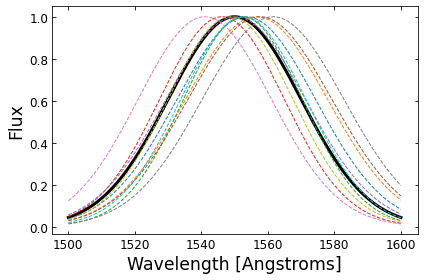

In [14]:
plt.plot(x, y_orig, 'k-', lw=3)

for i in range(10):
    plt.plot(x, y_new[i], ls='--', lw=1)
    
plt.ylabel('Flux')
plt.xlabel('Wavelength [Angstroms]')

Now let's calculate the FWHM for each of our new flux arrays

In [15]:
def FWHM(x, y):
    from scipy.interpolate import UnivariateSpline
    spline = UnivariateSpline(x, y - y.max() / 2, s = 0)
    a, b = spline.roots()
    return abs(a - b)

fwhm_orig = FWHM(x, y_orig)
fwhm_new = [FWHM(x, y) for y in y_new]

And now instead of calculating a single FWHM, we have a distribution of FWHMs. The mean of the distribution is an estimate of the original FWHM, and the standard deviation is the uncertainty. The new mean and std can then be used in calculating later quantities.

Original FWHM: 47.09650727848066
Mean FWHM: 47.04988503079066
Uncertainty: 2.3392421800074477


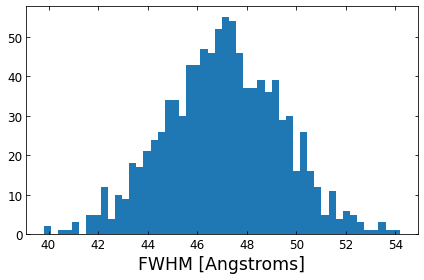

In [16]:
plt.hist(fwhm_new, bins=50);
plt.xlabel('FWHM [Angstroms]')
print('Original FWHM:', fwhm_orig)
print('Mean FWHM:', np.mean(fwhm_new))
print('Uncertainty:', np.std(fwhm_new))